# Land cover and urban heat islands

## Background

### Land cover
This notebook uses DEA Land Cover data. 
DEA Land Cover provides annual land cover classification for Australia using the Food and Agriculture Organisation Land Cover Classification System taxonomy. 
The dataset divides the landscape into six base land cover types:

* 111: Cultivated Terrestrial Vegetation (CTV)
* 112: (Semi-)Natural Terrestrial Vegetation (NTV) 
* 124: Natural Aquatic Vegetation (NAV)
* 215: Artificial Surface (AS)
* 216: Natural Bare Surface (NS)
* 220: Water

More information on the DEA Land Cover dataset can be found at [knowledge.dea.ga.gov.au](https://knowledge.dea.ga.gov.au/data/product/dea-land-cover-landsat/)

### Urban heat islands
Urban areas often experience higher temperatures than their rural surroundings, known as the urban heat island effect (UHI). Impervious surfaces in cities, such as buildings and pavement, are effective at accumulating and trapping heat. This heat is slowly released back into the environment at night, reducing nighttime cooling relief during summer. Other factors can further enhance UHI: cities lacking green infrastructure, such as trees, do not benefit from cooling through shade and evapotranspiration; rainwater directed away from cities becomes unavailable for soil-based evaporative cooling; and heat generated from human activities, such as transport and manufacturing.

UHI can be defined in different ways based on how energy is exchanged, scale variations, and how data is collected. The most accurate way to analyse UHI is by using air temperature, which is measured 2 meters above the ground. This height ensures that the ambient air temperature is captured independently of surface temperatures. Very few areas record air temperature, making large scale UHI analysis difficult. Many studies  overcome this problem by using land surface temperature (LST). LST data is readily available using remotely sensed data and provides a much cheaper alternative to recording field data. LST varies throughout the day, but are most similar to air temperatures in the morning. Therefore, studies that use LST note that it is only an appropriate measure for identifying spatial variations at a point in time as an indicator of UHI only.

In this notebook, we will use land cover/land use data and surface temperature data to understand this phenomenon. 

## Description
In this notebook we will: 

1. Load land cover and surface temperature data.
2. Investigate the relationship between land cover and surface temperature. 
3. Investigate the relationship between land cover and surface temperature at a suburban scale. 

***

## Start analysis

### Load packages
This section loads all the necessary libraries for data handling, analysis, and visualisation.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
from matplotlib import colors as mcolours
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import pystac_client
import planetary_computer
import odc.stac
import odc.geo.xr
from odc.geo.geom import BoundingBox
from shapely.geometry import box
import rioxarray
from rasterio.features import geometry_mask
from matplotlib.lines import Line2D

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.plotting import display_map
from dea_tools.landcover import plot_land_cover

### Connect to the datacube
Initialise a connection to the Datacube, which is used to load and analyze geospatial datasets

In [2]:
dc = datacube.Datacube(app='DEA_notebooks_template')

### Identify the analysis variables including study area and time period
Define the geographic coordinates (latitude and longitude) for an area of interest around Adelaide city center.

In [174]:
# Select a year to analyse
time = "2020"

# Coordinates for the Adelaide city center  
lat = -34.9232
lon = 138.6004
lat_buffer = 0.2
lon_buffer = 0.2

# Combine central coordinates with buffer values to create the latitude and longitude range for the analysis
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

display_map(x=lon_range, y=lat_range)

### Load land cover data
Query DEA Land Cover data for the specified location and time range. 
This data is used to analyze land cover types within the area of interest.

In [4]:
# Create a datacube query using the identified analysis variables
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time,
}

# Load DEA Land Cover data from the datacube
ds_lc = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements="level3",
    resolution=(-25, 25),
    **query
)

# Inspect the data
ds_lc

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 1, y: 1854, x: 1549)
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-01-01
  * y            (y) float64 15kB -3.806e+06 -3.806e+06 ... -3.852e+06
  * x            (x) float64 12kB 5.817e+05 5.817e+05 ... 6.204e+05 6.204e+05
    spatial_ref  int32 4B 3577
Data variables:
    level3       (time, y, x) uint8 3MB 220 220 220 220 220 ... 112 112 111 112
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Connect to Planetary Computer
Digital Earth Australia does not currently index Landsat surface temperature data.
To explore the relationship between land surface temperature and land cover type, connect to the Microsoft Planetary Computer (MPP) and access its Landsat 8 surface temperature dataset for the period of interest.
[Landsat surface temperature](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature) data can be found in the MPP [landsat-c2-l2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) collection. 
[Scaling factors](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products) are available to translate the data into temperature units (Kelvin).

In [5]:
# Open a client pointing to the Microsoft Planetary Computer data catalogue
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [175]:
# Search the catalogue for satellite acquisitions across the area and date/s of interest

# Convert data-cube style queries into something readable by `pystac_client`
bbox = BoundingBox.from_xy(lon_range, lat_range)
time_range = '2019-11/2020-02'

# Search the STAC metadata for items matching Landsat 8 collection 2 level 2 data only
search = catalog.search(
    collections="landsat-c2-l2",
    bbox=bbox,
    datetime=time_range,
    query={
        "platform": {"in": ["landsat-8"]},
    },
)

# Check how many items were returned
items = search.item_collection()
print(f"Found {len(items)} satellite acquisitions of LS8 surface temperature data for the dates and location of interest")

Found 22 satellite acquisitions of LS8 surface temperature data for the dates and location of interest


In [7]:
# Identify the surface temperature band name
max_key_length = len(max(items[0].assets, key=len))

for key, asset in items[0].assets.items():
    print(f'{key.rjust(max_key_length)}: {asset.title}')

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

Depending on how many datasets your query has found, it may take a few minutes to run the next two cells. 

In [8]:
# Load Landsat surface temperature data into this analysis (using ODC STAC)
ds_temp = odc.stac.load(
    items,
    bbox=bbox,
    bands=["lwir11"],
    crs="EPSG:3577",
    resolution=30,
    groupby="solar_day",
)

# Inspect outputs
ds_temp

<xarray.Dataset> Size: 60MB
Dimensions:      (y: 1546, x: 1291, time: 15)
Coordinates:
  * y            (y) float64 12kB -3.806e+06 -3.806e+06 ... -3.852e+06
  * x            (x) float64 10kB 5.817e+05 5.817e+05 ... 6.204e+05 6.204e+05
    spatial_ref  int32 4B 3577
  * time         (time) datetime64[ns] 120B 2019-11-06T00:40:07.154104 ... 20...
Data variables:
    lwir11       (time, y, x) uint16 60MB 41869 41872 41874 41876 ... 0 0 0 0

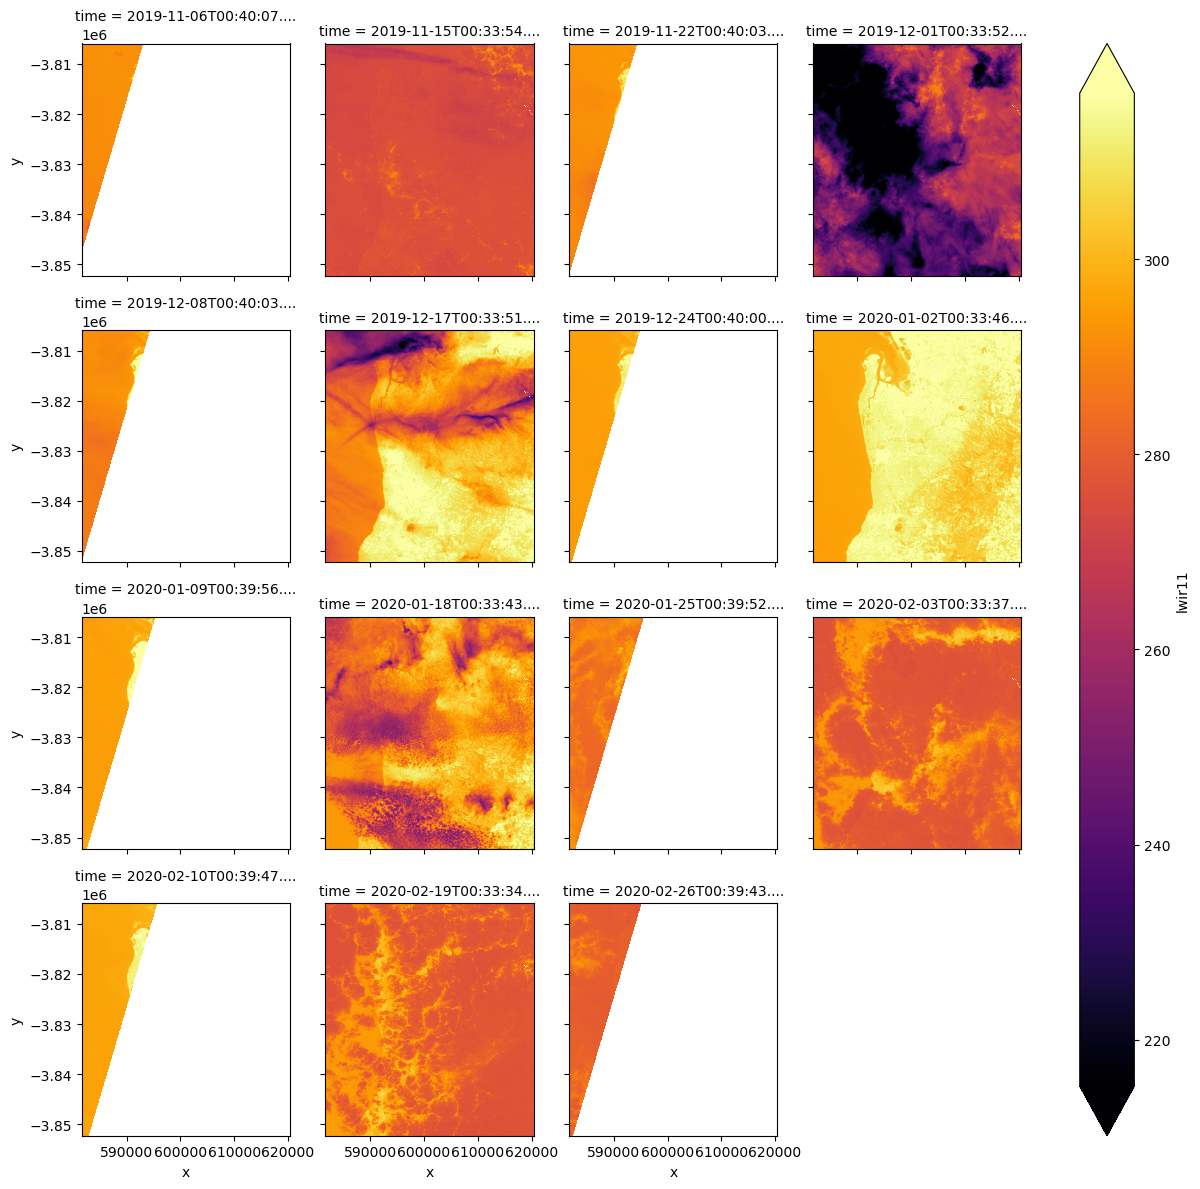

In [38]:
# Prepare and view the surface temperature data

# Set 0 values to nodata
ds_temp = ds_temp.where(ds_temp != 0)

# Apply USGS Collection 2 surface temperature scaling factors to obtain
# temperature in degrees Kelvin
ds_temp_K = ds_temp * 0.00341802 + 149.0

# Plot our temperature outputs
ds_temp_K.lwir11.plot.imshow(col="time", col_wrap=4, cmap="inferno", robust=True, add_labels=True)

Upon inspection of the 22 returned surface temperature datasets, all are either cloud-covered or incompletely detect the area of interest except for the acquisition on 2020-01-02.
Continue the analysis using surface temperature data for this date only.

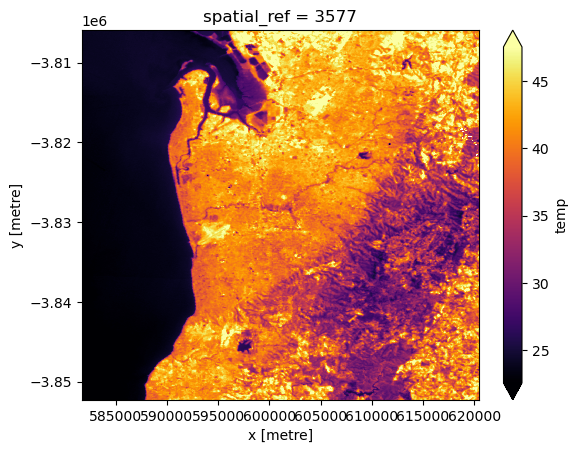

In [47]:
# Convert the cloud-free dataset to celsius
temp_K = ds_temp_K.isel(time=7)
temp = temp_K - 273.15

# Interpolate the land surface temperature values onto the pixel coordinates of DEA Land Cover
temp = temp.interp(x=ds_lc['x'], y=ds_lc['y'])

# Add the land surface temperature data to the land cover dataset
ds_lc = ds_lc.assign(temp=temp['lwir11'])

# Plot the land surface temperature
ds_lc.temp.plot.imshow(cmap="inferno", robust=True)

### Plot the data side by side

In [26]:
# Prepare the DEA Land Cover plotting configuration

# Nominate Land Cover classes and identify a labelling and colour scheme
landcover_colour_scheme = {
    0: (255, 255, 255, 255, "No Data"),
    111: (172, 188, 45, 255, "Cultivated terrestrial vegetation"),
    112: (14, 121, 18, 255, "Natural terrestrial vegetation"),
    124: (30, 191, 121, 255, "Natural aquatic vegetation"),
    215: (218, 92, 105, 255, "Artificial surface"),
    216: (243, 171, 105, 255, "Natural bare surface"),
    220: (77, 159, 220, 255, "Water"),
}

# Prepare the data labelling and colour mapping scheme for DEA Land Cover
def plot_layer(colours, data, ax):
    colour_arr = [np.array(value[:-2]) / 255 for value in colours.values()]
    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours.keys())
    bounds.append(bounds[-1] + 1)
    norm = mcolours.BoundaryNorm(bounds, cmap.N)
    labels = {
        'ticks': list(colours.keys()),
        'format': '%d'
    }
    im = data.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True, cbar_kwargs=labels)
    # ax.invert_yaxis()
    return im


Text(0.5, 1.0, 'DEA Land Cover')

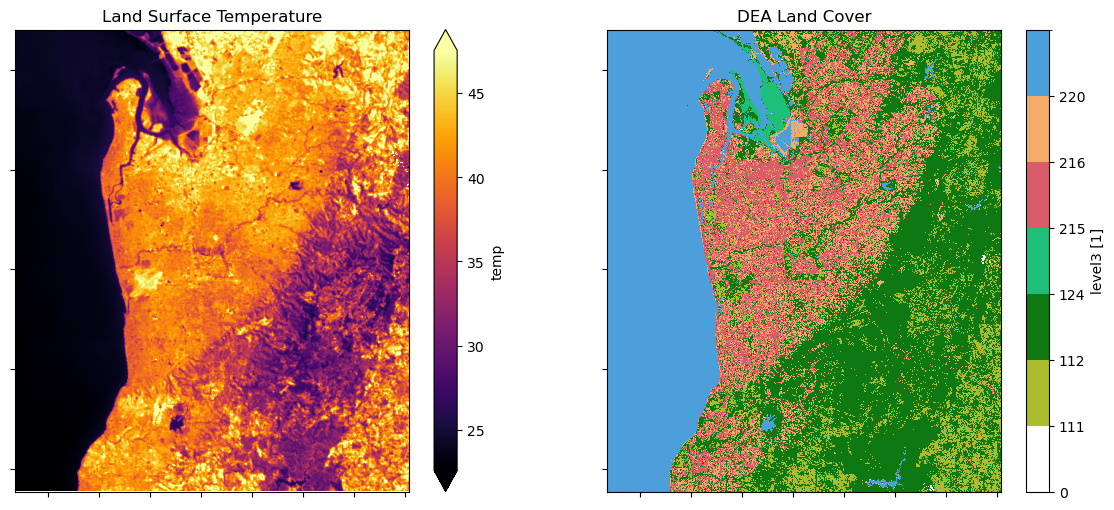

In [64]:
# Plot the land surface temperature and DEA Land Cover data side by side

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.set_title('Temp')
ds_lc.temp.plot.imshow(ax=ax1, cmap="inferno", robust=True)

ax2.set_title('Land Cover')
plot_layer(landcover_colour_scheme, ds_lc.level3, ax=ax2)

# Tidy the figures
ax1.label_outer()
ax1.set_xticklabels(labels="")
ax1.set_yticklabels(labels="")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title('Land Surface Temperature')

ax2.label_outer()
ax2.set_xticklabels(labels="")
ax2.set_yticklabels(labels="")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title('DEA Land Cover')

### Class analysis
Summarise the DEA Land Cover data by mean temperature per class

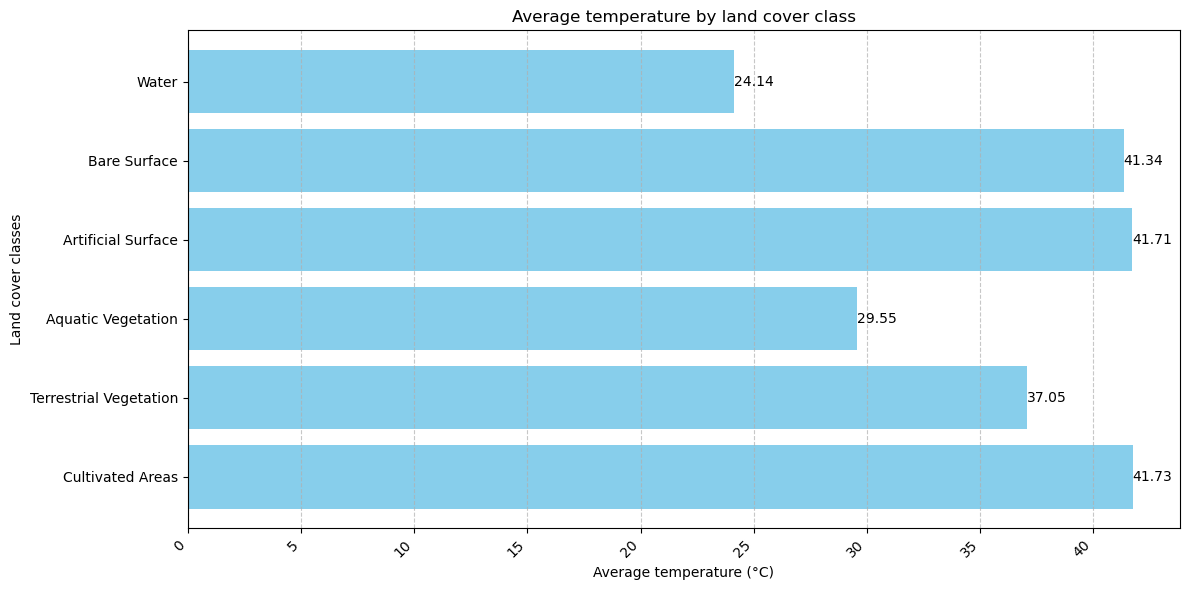

In [172]:
# Land Cover key
land_cover_names = {
    111: 'Cultivated Areas',
    112: 'Terrestrial Vegetation',
    124: 'Aquatic Vegetation',
    215: 'Artificial Surface',
    216: 'Bare Surface',
    220: 'Water'
}

# Extract the DEA Land Cover and Land Surface Temperature datasets
land_cover = ds_lc['level3']
temperature = ds_lc['temp']

# Create a new dataset and identify the mean temperature per cover class
data = xr.Dataset({'land_cover': land_cover, 'temperature': temperature})
average_temp_by_class = data.groupby('land_cover').mean()

# Drop land cover class: 0
average_temp_by_class = average_temp_by_class.where(average_temp_by_class.land_cover!=0, drop=True)

# Reassign coords to land cover names
average_temp_by_class = average_temp_by_class.assign_coords({"land_cover":list(land_cover_names.values())})

# Plot
plt.figure(figsize=(12, 6))
bars = average_temp_by_class.temperature.to_series().plot.barh(color='skyblue', width=0.8)
bars.bar_label(bars.containers[0], fmt='%.2f')

# Format plot
plt.ylabel('Land cover classes')
plt.xlabel('Average temperature (°C)')
plt.title('Average temperature by land cover class')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

### Suburb analysis
Statistical Area Level 2 (SA2) are medium-sized general purpose areas built to represent communities that interact together socially and economically. 
In the major cities, SA2s often represent single suburbs. 
Let's use this data to explore land surface temperature and cover between suburbs.

<Axes: >

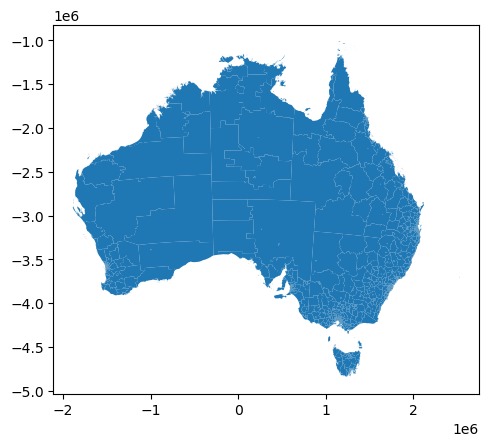

In [30]:
# read in data
data_sa2 = "https://dea-public-data-dev.s3.ap-southeast-2.amazonaws.com/abs_shapefiles/SA2_2021_Country.zip"
gdf_sa2= gpd.read_file(data_sa2)
gdf_sa2 = gdf_sa2.to_crs(epsg=3577)
gdf_sa2 = gdf_sa2.drop(columns=['SA2_CODE21', 'SA4_NAME21', 'SA3_CODE21', 'GCC_CODE21', 'SA3_NAME21', 
                                'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'SA4_CODE21', 
                                'AUS_CODE21', 'AUS_NAME21', 'LOCI_URI21', 'MinSimpTol', 'Population', 
                                'Dwellings'])
gdf_sa2.plot()

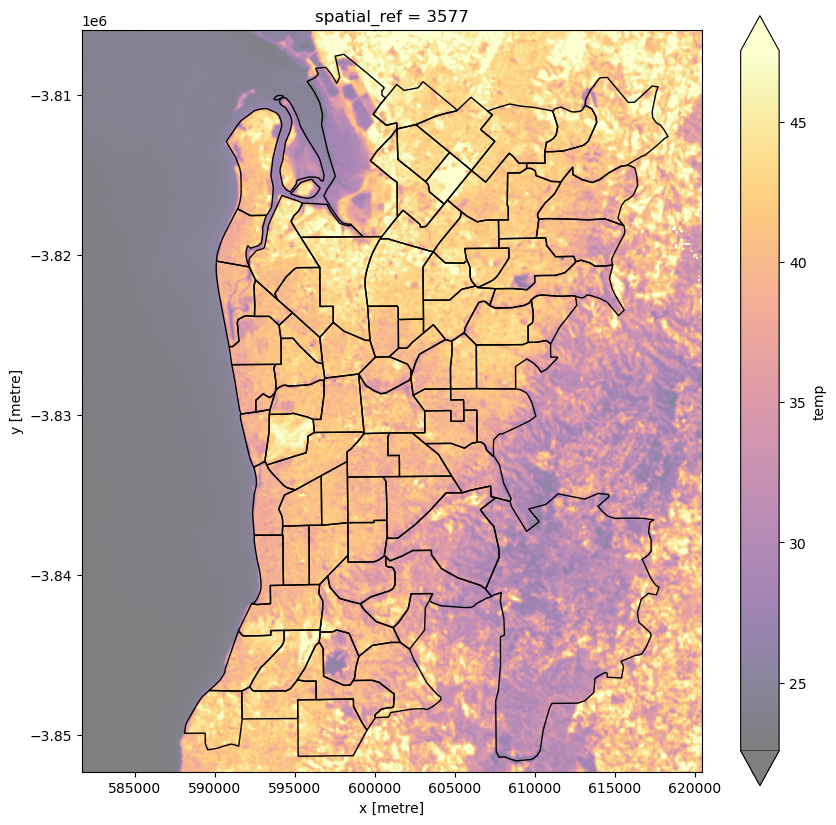

In [186]:
# Extract and show the suburb polygons in the area of interest

# get the bounding box of the temp data
minx, maxx = ds_lc.x.min().item(), ds_lc.x.max().item()
miny, maxy = ds_lc.y.min().item(), ds_lc.y.max().item()
bbox = box(minx, miny, maxx, maxy)

# clip the shapefiles to the temperature data extent
gdf_clipped = gdf_sa2[gdf_sa2.within(bbox)].copy()

# plot over temperature data
fig, ax = plt.subplots(figsize=(10, 10))
temperature = ds_lc.temp
temperature.plot(ax=ax, cmap='inferno', alpha=0.5, robust=True)
gdf_clipped.boundary.plot(ax=ax, color='black', linewidth=1)
plt.show()

In [188]:
# aggregate surface temp data over each suburb

# remember: we are using a single date satellite acquisition of 
# land surface data. Our data, dated 2020-01-02, represents
# mid summer in Adelaide.

temperature = ds_lc.temp
avg_temperatures = []

# loop through each segment in the shapefile
for idx, row in gdf_clipped.iterrows():
    # mask the temp data using the segment geometry
    masked_temp = temperature.rio.clip([row['geometry']], all_touched=True, drop=False)
    
    # cal the average temp
    avg_temp = masked_temp.mean().item()
    
    # save result
    avg_temperatures.append(avg_temp)

# add avg temp to data 
gdf_clipped['avg_temperature'] = avg_temperatures

# print
pd.set_option('display.max_rows', None)
gdf_sorted = gdf_clipped.sort_values(by='avg_temperature', ascending=False)
gdf_sorted[['SA2_NAME21', 'avg_temperature']].head()

,SA2_NAME21,avg_temperature
1752,Parafield,46.901522
1816,Adelaide Airport,44.232846
1754,Paralowie,43.984102
1747,Northgate - Northfield,43.707131
1814,The Parks,43.684026


In [33]:
# aggregate land cover over each suburb
land_cover = ds_lc['level3']  

most_common_land_cover = []
count_111 = []
count_112 = []
count_124 = []
count_215 = []
count_216 = []
count_220 = []

# loop through each segment in the shapefile
for idx, row in gdf_clipped.iterrows():
    # mask land cover data using the segment geometry
    masked_lc = land_cover.rio.clip([row['geometry']], all_touched=True, drop=False)
    
    # flatten and remove NaN and zero values
    masked_lc_values = masked_lc.values.flatten()
    masked_lc_values = masked_lc_values[~np.isnan(masked_lc_values)]
    masked_lc_values = masked_lc_values[masked_lc_values != 0]
    
    # calculate the most common land cover class
    if len(masked_lc_values) > 0:
        values, counts = np.unique(masked_lc_values, return_counts=True)
        mode_lc = values[np.argmax(counts)]
    else:
        mode_lc = np.nan 
    most_common_land_cover.append(mode_lc)
    
    # count occurrences of each specific land cover class
    counts_dict = {111: 0, 112: 0, 124: 0, 215: 0, 216: 0, 220: 0}
    for value in masked_lc_values:
        if value in counts_dict:
            counts_dict[value] += 1
    
    # add counts to corresponding lists
    count_111.append(counts_dict[111])
    count_112.append(counts_dict[112])
    count_124.append(counts_dict[124])
    count_215.append(counts_dict[215])
    count_216.append(counts_dict[216])
    count_220.append(counts_dict[220])

# add the results to the DataFrame
gdf_clipped['most_common_land_cover'] = most_common_land_cover
gdf_clipped['count_111'] = count_111
gdf_clipped['count_112'] = count_112
gdf_clipped['count_124'] = count_124
gdf_clipped['count_215'] = count_215
gdf_clipped['count_216'] = count_216
gdf_clipped['count_220'] = count_220

In [34]:
gdf_clipped.head()

,SA2_NAME21,GCC_NAME21,AREASQKM21,geometry,avg_temperature,most_common_land_cover,count_111,count_112,count_124,count_215,count_216,count_220
1710,Adelaide,Greater Adelaide,10.4824,"POLYGON ((598981.671 -3827435.103, 599441.128 ...",40.527631,112,2903,6152,0,5666,2288,175
1711,North Adelaide,Greater Adelaide,5.0909,"POLYGON ((600033.166 -3826378.314, 600892.529 ...",39.622875,112,1855,3405,0,1933,1197,149
1713,Aldgate - Stirling,Greater Adelaide,117.2141,"POLYGON ((607431.079 -3836951.904, 607142.044 ...",32.509816,112,20051,165160,22,446,1809,1672
1720,Burnside - Wattle Park,Greater Adelaide,11.3050,"POLYGON ((605539.227 -3829045.594, 605146.807 ...",38.244468,112,571,10482,0,2439,5086,0
1721,Beaumont - Glen Osmond,Greater Adelaide,9.5264,"POLYGON ((603957.763 -3832440.300, 603924.961 ...",36.977198,112,1003,11264,0,1235,2677,0


In [190]:
# Prepare land cover data for plotting

cmap_list = [(v[0]/255.0, v[1]/255.0, v[2]/255.0, v[3]/255.0) for v in landcover_colour_scheme.values()]
bounds = sorted(landcover_colour_scheme.keys())
norm = mcolours.BoundaryNorm(boundaries=bounds + [max(bounds) + 1], ncolors=len(bounds))

cmap = mcolours.ListedColormap(cmap_list)

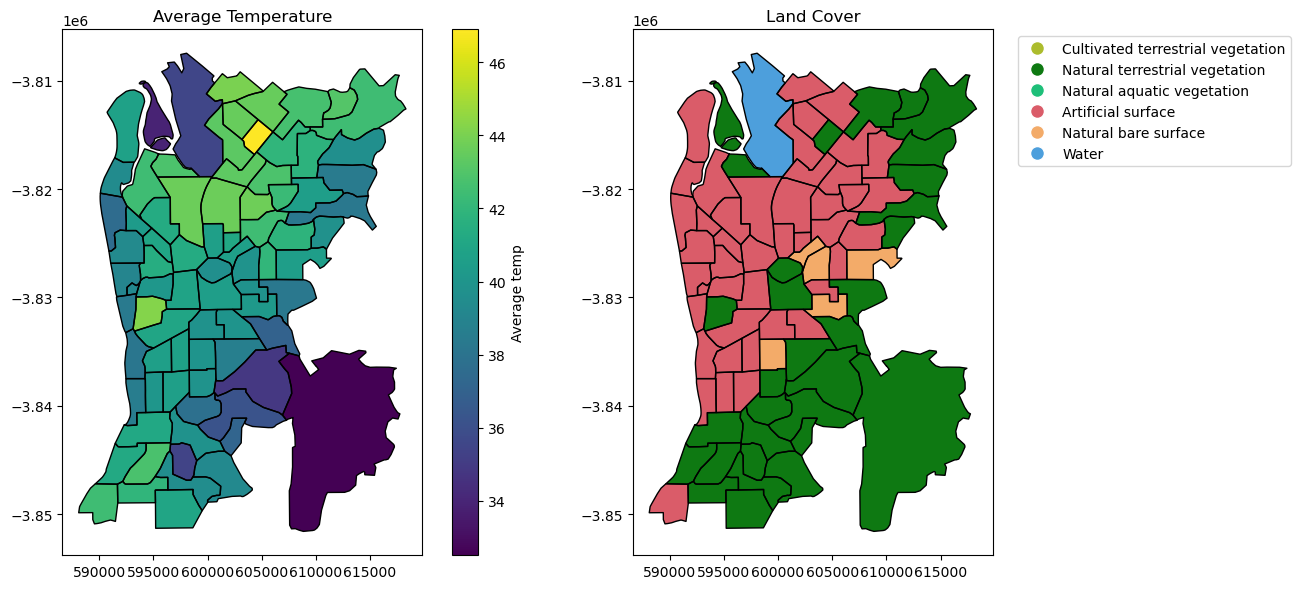

In [36]:
# Plot the average temperature on 2020-01-02 per suburb alongside the average DEA Land Cover per suburb for 2020
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

gdf_clipped.plot(ax=ax1, column='avg_temperature', cmap='viridis', legend=True, legend_kwds={"label": "Average temp"})
gdf_clipped.boundary.plot(ax=ax1, color='black', linewidth=1)
ax1.set_title('Average Temperature')

gdf_clipped.plot(ax=ax2, column='most_common_land_cover', cmap=cmap, norm=norm, legend=False)
gdf_clipped.boundary.plot(ax=ax2, color='black', linewidth=1)
ax2.set_title('Land Cover')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_list[i], markersize=10, label=landcover_colour_scheme[key][4])
                   for i, key in enumerate(landcover_colour_scheme) if key != 0]  # Exclude 'No Data'

ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Plot relationship 
Explore the relationship between land cover type and land surface temperature, at the SA2 (~suburb) level

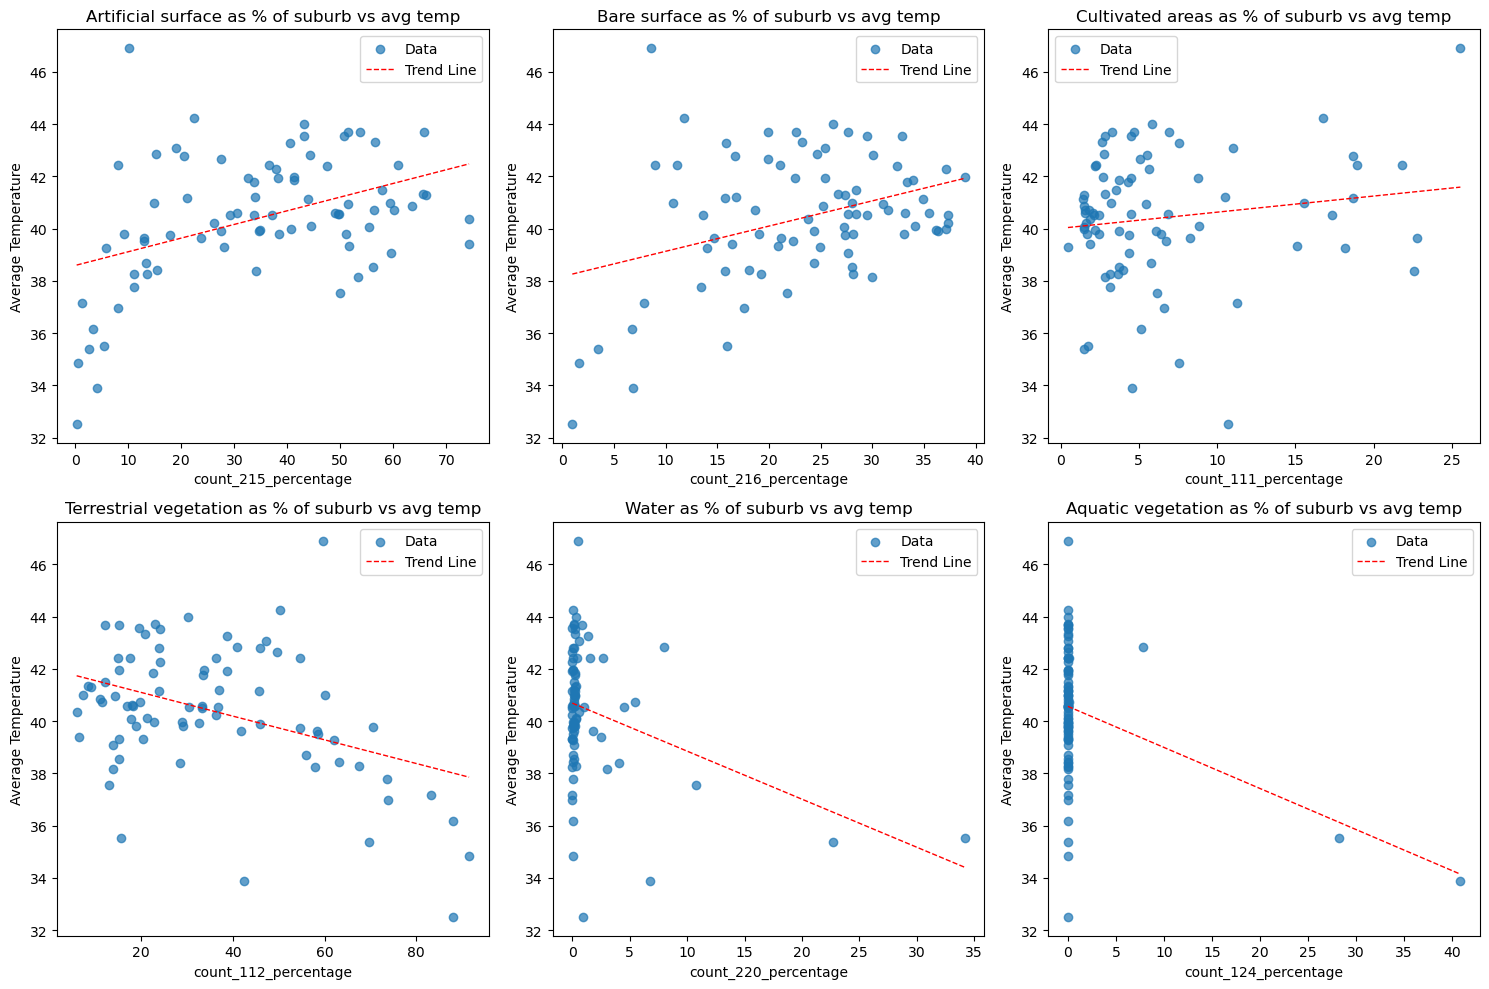

In [37]:
land_cover_columns = ['count_111', 'count_112', 'count_124', 'count_215', 'count_216', 'count_220']

for col in land_cover_columns:
    percentage_col = col + '_percentage'
    gdf_clipped[percentage_col] = (gdf_clipped[col] * (25**2) / 1_000_000 / gdf_clipped['AREASQKM21']) * 100


land_cover_classes = ['count_215_percentage', 'count_216_percentage', 'count_111_percentage', 'count_112_percentage', 'count_220_percentage', 'count_124_percentage']

titles = [
    'Artificial surface as % of suburb vs avg temp',
    'Bare surface as % of suburb vs avg temp',
    'Cultivated areas as % of suburb vs avg temp',
    'Terrestrial vegetation as % of suburb vs avg temp',
    'Water as % of suburb vs avg temp',
    'Aquatic vegetation as % of suburb vs avg temp'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10)) 
axes = axes.flatten() 

for i, (land_cover_class, title) in enumerate(zip(land_cover_classes, titles)):
    ax = axes[i]
    ax.scatter(gdf_clipped[land_cover_class], gdf_clipped['avg_temperature'], alpha=0.7, label='Data')
    x = gdf_clipped[land_cover_class]
    y = gdf_clipped['avg_temperature']
    coeffs = np.polyfit(x, y, 1)
    trend_line = np.poly1d(coeffs)
    x_range = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_range, trend_line(x_range), color='red', linestyle='--', linewidth=1, label='Trend Line')
    ax.set_title(title)
    ax.set_xlabel(f'{land_cover_class}')
    ax.set_ylabel('Average Temperature')
    ax.legend()
plt.tight_layout() 
plt.show()

### Interpretation
I think the above plots need a few words to explain how the land cover percentages were derived and how to interpret these plots.

### Extension
If continuing this exercise, some ideas for further analysis include:
* exploring other climate variables and their relationship with land cover type e.g. [Working with ERA5 climate data](How_to_guides/External_data_ERA5_Climate.ipynb)
* run this analysis for your own area of interest
* compare the summer vs winter urban heat island effect